In [1]:
import matplotlib.pyplot as plt
import numpy as np 
from numpy import linspace
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
from scipy.stats import gaussian_kde
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv('data/02_clean_loans50k.csv', index_col=0)

In [3]:
df.head().T

,0,1,2,3,4
loanID,188861,517703,268587,579902,617630
amount,8000.0,11000.0,35000.0,20000.0,12000.0
term,36 months,36 months,36 months,60 months,60 months
rate,0.14,0.1,0.15,0.12,0.12
payment,272.07,354.89,1220.33,447.83,266.88
grade,C,B,D,C,B
employment,Warehouseman,Vice President,Owner/Attorney,Analyst,medical technician
length,3 years,10+ years,10+ years,2 years,10+ years
home,RENT,MORTGAGE,RENT,MORTGAGE,MORTGAGE
income,49966.0,50000.0,360000.0,60000.0,64000.0


**Quite a large amount of the info is text data, rather than numerical.**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49184 entries, 0 to 49998
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   loanID       49184 non-null  int64  
 1   amount       49184 non-null  float64
 2   term         49184 non-null  object 
 3   rate         49184 non-null  float64
 4   payment      49184 non-null  float64
 5   grade        49184 non-null  object 
 6   employment   49184 non-null  object 
 7   length       49184 non-null  object 
 8   home         49184 non-null  object 
 9   income       49184 non-null  float64
 10  verified     49184 non-null  object 
 11  status       49184 non-null  object 
 12  reason       49184 non-null  object 
 13  state        49184 non-null  object 
 14  debtIncRat   49184 non-null  float64
 15  delinq2yr    49184 non-null  float64
 16  inq6mth      49184 non-null  float64
 17  openAcc      49184 non-null  float64
 18  pubRec       49184 non-null  float64
 19  revo

**I changed Source Verified to match the other entries as 'Verified'. <br> Lastly, I dropped the 'totalPaid' as this feature isn't created until after the loan is issued and cannot be used as a predictor of default**

In [5]:
df.status.value_counts()

Current    41604
Default     7580
Name: status, dtype: int64

In [6]:
percent_default = round(len(df[df.status == 'Default']) / len(df.status)  * 100,2)
print('Percent of data that is Status default', percent_default)

Percent of data that is Status default 15.41


In [7]:
df['verified'] = df['verified'].replace(['Source Verified'], 'Verified')
df = df.drop(['totalPaid'], axis=1)

**Next I wanted to check what correlations exist in the data. Since there was a 99% correlation between totalBal and totalLim, I removed the totalLim feature as it doesn't provide additional information.**

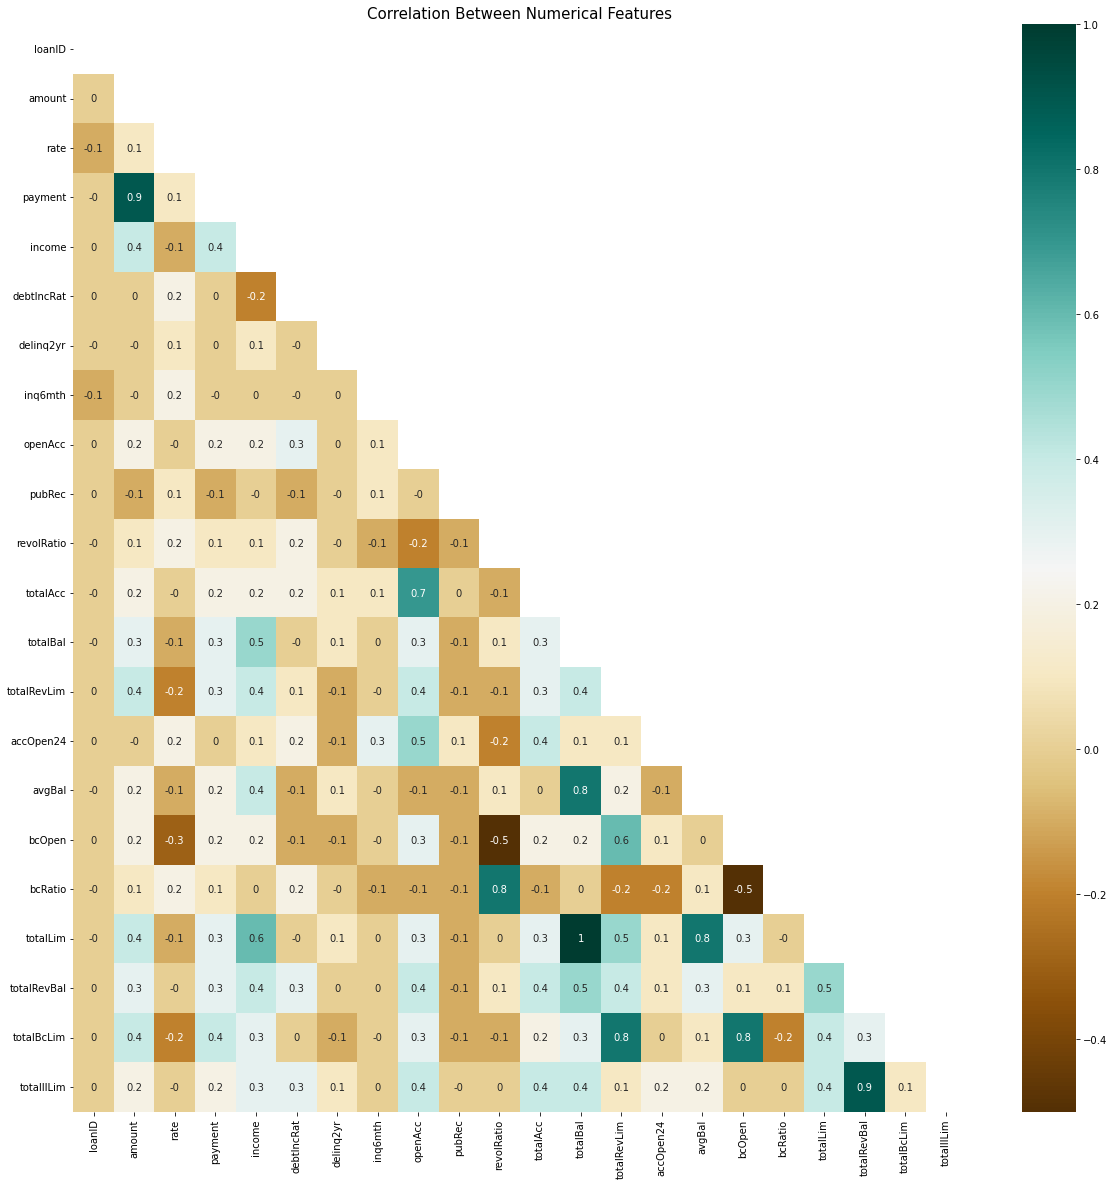

In [8]:
# Create a correlation matrix
corr = round(df.corr(), 1)

# Create a mask to hide the upper triangle of the heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with the mask
plt.figure(figsize=(20, 20))
ax = sns.heatmap(corr, annot=True, cmap='BrBG', mask=mask)
plt.title('Correlation Between Numerical Features', size=15)

# Save the figure as a PNG image
plt.savefig('Images/Heatmap', dpi=300, bbox_inches='tight')

plt.show()

In [9]:
# Drop totalLim feature
df = df.drop(['totalLim'], axis=1)

**Confirm that loanIDs are all unqiue. Since they are, I will use the loanID as the index.**

In [10]:
# Check shape to compare against length of unique loanIDs
df.shape

(49184, 30)

In [11]:
# Confirm all loanIDs are unique
df.loanID.nunique()

49184

**Replace existing index with loanID column. Rate, payment & grade are determined by the bank after approving the loan. These are not predictive features.**

In [12]:
df = df.drop(['rate', 'payment', 'grade'], axis=1).set_index('loanID')

**I wanted to see if the employmet field could be used as a predictor. There are over 18,000 unique professions. I also looked to see how many might be duplicates by looking at any employment that contains 'nurse.' There are many that could be grouped but some are pretty different (like registered nurse vs certified nurse assistant). In the end, it's too much to figure out so I dropped that feature. I still have (employment) length so I am able to capture some of a related feature.**

In [13]:
df.employment = df.employment.str.lower()

In [14]:
df.employment.nunique()

18272

In [15]:
search_word = 'nurse'
pattern = f'.*{search_word}.*'  # regular expression pattern to match any string that contains the search_word
result = df[df['employment'].str.contains(pattern)]
result.head(10)

,amount,term,employment,length,home,income,verified,status,reason,state,...,totalAcc,totalBal,totalRevLim,accOpen24,avgBal,bcOpen,bcRatio,totalRevBal,totalBcLim,totalIlLim
loanID,,,,,,,,,,,,,,,,,,,,,
281259,10000.0,36 months,registered nurse,2 years,RENT,75000.0,Not Verified,Current,debt_consolidation,CA,...,31.0,93495.0,39900.0,2.0,4921.0,31333.00,10.7,93495.0,35100.0,101320.0
54149,18825.0,60 months,nurse,1 year,MORTGAGE,53000.0,Verified,Current,debt_consolidation,IL,...,12.0,197390.0,13600.0,5.0,28199.0,1868.00,75.4,44885.0,7600.0,44953.0
281495,17000.0,36 months,registered nurse,7 years,MORTGAGE,140000.0,Not Verified,Current,credit_card,CA,...,32.0,506667.0,47800.0,6.0,31667.0,12753.00,62.4,36045.0,33900.0,30108.0
351772,6000.0,36 months,certified nurse assistant,2 years,RENT,20000.0,Verified,Default,home_improvement,CA,...,19.0,38782.0,14000.0,8.0,2155.0,9855.00,4.3,38782.0,10300.0,35250.0
616263,8675.0,36 months,travel nurse,< 1 year,RENT,56400.0,Not Verified,Current,house,SC,...,15.0,29088.0,5800.0,2.0,2909.0,9154.93,63.2,29088.0,0.0,29997.0
214963,25000.0,36 months,reg nurse,2 years,MORTGAGE,150000.0,Verified,Current,debt_consolidation,MD,...,21.0,463748.0,31800.0,0.0,51528.0,3699.00,87.6,39625.0,29800.0,18006.0
345517,28000.0,36 months,nurse- aprn,10+ years,MORTGAGE,110000.0,Not Verified,Current,debt_consolidation,SC,...,32.0,134087.0,109200.0,1.0,7449.0,38235.00,48.1,48256.0,73700.0,14986.0
455922,23550.0,36 months,registered nurse,< 1 year,OWN,56100.0,Verified,Current,debt_consolidation,VA,...,29.0,43342.0,10600.0,3.0,8668.0,342.00,82.9,43342.0,2000.0,44928.0
397210,9000.0,36 months,public health nurse,1 year,RENT,62000.0,Verified,Current,medical,CO,...,21.0,49724.0,12300.0,2.0,4972.0,2792.00,71.5,49724.0,9800.0,61942.0


In [16]:
df = df.drop('employment', axis=1)

**Separate the features and target variable. Use chi-squared test to look see which features might make the biggest impact in when modeling later.**

In [17]:
X = df.drop('status', axis=1)
y = df['status']

In [18]:
len(X.columns)

24

In [34]:
# Calculate the chi-squared test statistic and p-value for each feature
chi2, p_values = [], []
for feature in X.columns:
    contingency_table = pd.crosstab(X[feature], y)
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
    chi2.append(chi2_stat)
    p_values.append(p_value)

# Select the top k features with the highest chi-squared test statistic
k = 5
top_features_chi = X.columns[np.argsort(chi2)[-k:]]
top_scores_chi = np.sort(chi2)[-k:]

# Select the top k features with the lowest p-values
top_features_p = X.columns[np.argsort(p_values)[:k]]
top_scores_p = np.sort(p_values)[:k]

# Create a dataframe with the selected features and their scores
features_scores_df = pd.DataFrame({
    'Feature': np.concatenate((top_features_chi, top_features_p)),
    'Chi Squared': np.concatenate((top_scores_chi, np.zeros(k))),
    'P-Values': np.concatenate((np.zeros(k), top_scores_p))
})

# Sort the dataframe by the chi-squared test statistic score
features_scores_df = features_scores_df.sort_values('Chi Squared', ascending=False)

# Reset the index of the dataframe
features_scores_df = features_scores_df.reset_index(drop=True)

In [41]:
features_scores_df

,Feature,Chi Squared,P-Values
0,totalBal,44053.736608,0.000000e+00
1,totalRevBal,38634.197000,0.000000e+00
2,totalIlLim,32945.336049,0.000000e+00
3,avgBal,22435.096839,0.000000e+00
4,bcOpen,17367.455814,0.000000e+00
5,accOpen24,0.000000,1.830568e-164
6,term,0.000000,5.490641e-89
7,inq6mth,0.000000,1.026460e-77
8,verified,0.000000,8.902881e-52
9,amount,0.000000,1.093108e-47


In [29]:
# Creat lists of the top chi2 and p-value scores
top_chi2 = sorted(chi2, reverse = True)[:5]
top_pvals = sorted(p_values, reverse = True)[:5]

# Creat a dataframe with those featues
top_features = pd.DataFrame({'Chi Squared':top_features_chi, 'P-Values':top_features_p})

In [30]:
top_features

,Chi Squared,P-Values
0,bcOpen,accOpen24
1,avgBal,term
2,totalIlLim,inq6mth
3,totalRevBal,verified
4,totalBal,amount


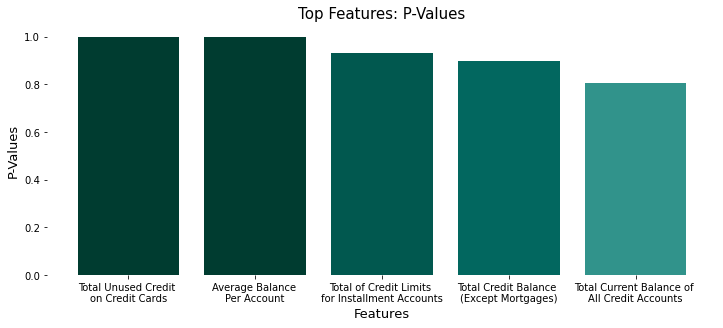

In [31]:
# Make bar chart for P-Value Top Scores
# Create a color gradient for the bar chart
color_map = plt.cm.get_cmap('BrBG')

x_labels = ['Total Unused Credit \non Credit Cards','Average Balance \nPer Account',\
                                      'Total of Credit Limits \nfor Installment Accounts',\
                                      'Total Credit Balance \n(Except Mortgages)',\
                                      'Total Current Balance of \nAll Credit Accounts']

# Plot the top P-Values results with a color gradient
plt.figure(figsize=(12, 6))
bars = plt.bar(top_features_p, top_pvals, color=color_map(top_pvals / max(top_pvals)))
plt.xticks(range(len(top_features)), x_labels)
plt.xlabel('Features', size=13)
plt.ylabel('P-Values', size=13)
plt.title('Top Features: P-Values', size=15)

# Add horizontal lines behind the bars.
for i in range(1, 1):
    plt.axhline(y=i/10, color='lightblue', zorder=-1, linewidth=0.5)

# Add space between the bars
plt.subplots_adjust(bottom=0.3)

# Remove the spines of the plot & box around the legend
sns.despine(bottom=True, left=True)

# Save the figure as a PNG image
plt.savefig('Images/Top Features: P-Values', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Make bar chart for Chi2 Top Scores
# Create a color gradient for the bar chart
color_map = plt.cm.get_cmap('BrBG')

x_labels = ['Total Unused Credit \non Credit Cards','Average Balance \nPer Account',\
                                      'Total of Credit Limits \nfor Installment Accounts',\
                                      'Total Credit Balance \n(Except Mortgages)',\
                                      'Total Current Balance of \nAll Credit Accounts']

# Plot the top Chi2 results with a color gradient
plt.figure(figsize=(12, 6))
bars = plt.bar(top_features_chi, top_chi2, color=color_map(top_chi2 / max(top_chi2)))
plt.xticks(range(len(top_features)), labels=x_labels)
plt.xlabel('Features', size=13)
plt.ylabel('Chi-Squared Test Statistic', size=13)
plt.title('Top Features: Chi-Squared Test Statistic', size=15)

# Add horizontal lines behind the bars
for i in [10000, 20000, 30000, 40000]:
    plt.axhline(y=i, color='lightblue', zorder=-1, linewidth=0.5)

# Add space between the bars
plt.subplots_adjust(bottom=0.3)

# Remove the spines of the plot & box around the legend
sns.despine(bottom=True, left=True)

# Save the figure as a PNG image
plt.savefig('Images/Top Features: Chi-Squared Test Statistic', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
top_features

In [ ]:
X = X[top_features]

**I was curious about a possible relation between loan status and 'debtIncRat'. Looks like is a slighly higher trend for those who default.**

In [ ]:
sns.catplot(data=df, x="status", y='debtIncRat', kind="box", palette={"Default": "goldenrod", "Current": "teal"})

# Set the title & labels for the x-axis & y-axis
plt.title("Defaulters Have A Highter \nDebt to Income Ratio", size=15)
plt.xlabel('Loan Status', size=13)
plt.ylabel('Dent to Income Ratio', size=13)

# Remove the spines of the plot & box around the legend
sns.despine(bottom=True, left=True)

# Save the figure as a PNG image
plt.savefig('Images/Defaulter Box Plot', dpi=300, bbox_inches='tight')

plt.show()

**I wanted to see if there was a difference in defaults based on home ownership. Looks like home owners and those with mortages are muhc more prone to defult than those that rent.**

In [ ]:
df.home.unique()

In [ ]:
rent = df[(df['home'] == 'RENT') & (df['status'] == 'Default')]
mortgage = df[(df['home'] == 'MORTGAGE') & (df['status'] == 'Default')]
own = df[(df['home'] == 'OWN') & (df['status'] == 'Default')]

home_values = pd.DataFrame({'home': ['OWN', 'MORTGAGE', 'RENT'], 'default': [len(rent), len(mortgage), len(own)]})
home_totals = pd.DataFrame(df['home'].value_counts()).reset_index()
home_totals.rename(columns = {'index':'home', 'home':'count'}, inplace = True)

home_summary = pd.merge(home_values, home_totals)
home_summary['%'] = (100*home_summary['default']/home_summary['count']).round(2)
home_summary = home_summary.sort_values(by=['%'], ascending=False)

In [ ]:
home_summary

In [ ]:
y_pos = np.arange(len(home_summary['home']))
plt.bar(y_pos, home_summary['%'], width = .5, color='goldenrod')

# Create a list of labels with the first letter capitalized
labels = [s.capitalize() for s in home_summary['home']]

plt.xticks(y_pos, labels)

# Set the title & labels for the x-axis & y-axis
plt.title("Homeowners Default Much More", size=15)
plt.xlabel('Home Status', size=13)
plt.ylabel('Number of Defaults', size=13)

# Remove the spines of the plot & box around the legend
sns.despine(bottom=True, left=True)
plt.yticks(size=10, color='grey')

# Save the figure as a PNG image
plt.savefig('Images/Dont Loan Money to Homeowners', dpi=300, bbox_inches='tight')

plt.show()

**I wanted to try the same experiment with the reason the loan was originated. I speculated that debt consolodation would be the feature with the highest percentage of defaults. Turns out Small Business loans were by far the highest.**

In [ ]:
df.reason.unique()

In [ ]:
default_by_reason = {reason: group[group['status'] == 'Default'] for reason, group in df.groupby('reason')}

In [ ]:
credit_card = default_by_reason['credit_card']
debt_consolidation = default_by_reason['debt_consolidation']
other = default_by_reason['other']
car = default_by_reason['car']
home_improvement = default_by_reason['home_improvement']
vacation = default_by_reason['vacation']
medical = default_by_reason['medical']
small_business = default_by_reason['small_business']
house = default_by_reason['house']
moving = default_by_reason['moving']
major_purchase = default_by_reason['major_purchase']
renewable_energy = default_by_reason['renewable_energy']
wedding = default_by_reason['wedding']

In [ ]:
values = pd.DataFrame({'reason': list(default_by_reason.keys()), 'defaults': [len(default_by_reason[reason]) for reason in default_by_reason]})

In [ ]:
total_values = pd.DataFrame(df['reason'].value_counts()).reset_index()
total_values

In [ ]:
total_values.rename(columns = {'index':'reason', 'reason':'count'}, inplace = True)

In [ ]:
reason_summary = pd.merge(values, total_values)
reason_summary['%'] = (100*reason_summary['defaults']/reason_summary['count']).round(2)
reason_summary = reason_summary.sort_values(by=['%'], ascending=False)
reason_summary.reset_index(inplace=True)

In [ ]:
reason_summary.drop(['index'], axis=1)

In [ ]:
reason_summary.reason

In [ ]:
reasons = ['Wedding', 'Car', 'Credit Card', 'Home Improvement', 'Major Purchase', 'Debt Consolidation',\
           'Renewable Energy', 'Other', 'Vacation', 'House', 'Medical', 'Moving', 'Small Business']
reasons.reverse()

In [ ]:
my_range=range(1,len(reason_summary.index)+1)

plt.hlines(y=my_range, xmin=0, xmax=reason_summary['%'], color='goldenrod', linestyle='dotted')
plt.plot(reason_summary['%'], my_range, "o", color='goldenrod')
plt.yticks(my_range, reasons)
plt.xlabel('Percentage of Defaults', size=13)
plt.title("Small Businesses Are Doomed.", size=15)

# Remove the spines of the plot & box around the legend
sns.despine(bottom=True, left=True)

# Save the figure as a PNG image
plt.savefig('Images/Small Businesses Are Doomed', dpi=300, bbox_inches='tight')

plt.show()

**I separated Current & Default into their own dataframes and created samples of 1000 from each for easier visualization. I did a quick histogram of the separated dataframes to compare to each other.**

In [ ]:
default = df[df['status']=='Default']
current = df[df['status']=='Current']

default_sample = default.sample(1000)
current_sample = current.sample(1000)
df_sample=df.sample(1000)

In [ ]:
figsize=(10, 10)
default.hist(figsize=(15, 10), bins=15, color='goldenrod')
plt.subplots_adjust(hspace=0.5)
current.hist(figsize=(15, 10), bins=15, color='teal')
plt.subplots_adjust(hspace=0.5)
plt.show()

**I tried using describe on each of the newly created dataframes and then subtracted them from each other to see if there were any large diferences. Becuase the data is scaled very differently, it was hard to eaily see what differences might be important. And beyond that, because the data is not normally distributed, these metrics are not as helpful.**

In [ ]:
default_info = default.describe()
current_info = current.describe()

default_info = default_info.drop('count')
current_info = current_info.drop('count')

In [ ]:
default_info.subtract(current_info, axis = 1).T

**I looked at the difference between the 50th percentiles (medians). Looks like there are some noticable features that might be relevant later on.**

In [ ]:
median_diffs = pd.DataFrame(default.median() - current.median())
median_diffs.columns = ['Diffs']
median_diffs.T

**I looked at why people were getting a loan vs. their income. I used status to further separate the data on the plot.**

In [ ]:
df.columns

In [ ]:
# Replace underscores with spaces and capitalize each word in 'reason' column
df['reason'] = df['reason'].str.replace('_', ' ').str.title()

# Create a figure and axis with a specified size
fig, ax = plt.subplots(figsize=(20,10))

# Create a custom color palette
custom_palette = {'Current': 'teal', 'Default': 'goldenrod'}

# Create a strip plot showing the relationship between the modified 'reason' column and the 'income' column, 
# with the 'status' column as the hue, using the custom palette
sns.stripplot(x='reason', y="income", data=df, hue='status', palette=custom_palette, jitter=False, size=15, dodge=True, marker='o')

# Set the y-axis limits
plt.ylim(-10000,900000)

# Set the title & labels for the x-axis & y-axis
plt.title('Reason for Loan Versus Income', loc='center', size=15)
plt.xlabel('Reason for Loan', size=13)
plt.ylabel('Income', size=13)

# Remove the spines of the plot & box around the legend
sns.despine(bottom=True, left=True)
plt.legend(frameon=False, title='Loan Status')

# Save the figure as a PNG image with a specified resolution and tight bounding box
plt.savefig('Images/Reason for Loan versus Income', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

**Below I used sampled data to scatterplot the revolRatio (Revolving Ratio) against the totalBcLim (total credit limits of credit cards)and added a regression line for both Current & Defaul loans.**

In [ ]:
x1, y1 = default_sample['revolRatio'], default_sample['totalBcLim']
x2, y2 = current_sample['revolRatio'], current_sample['totalBcLim']

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis with a specified size
fig, ax = plt.subplots(figsize=(20,10))

# Create scatter plots for two datasets
ax.scatter(x1, y1, color='goldenrod', label='Default', alpha=.5)
ax.scatter(x2, y2, color='teal', label = 'Current', alpha=.5)

# Perform linear regression for each dataset and plot the resulting line
m, b = np.polyfit(x1, y1, 1)
plt.plot(x1, m*x1+b)

m, b = np.polyfit(x2, y2, 1)
plt.plot(x2, m*x2+b)

# Set the y-axis limits
plt.ylim(-20,120000)

# Set the title of the plot and labels for the x-axis & y-axis
ax.set_title('Revolving Ratio vs Payment', size=15)
ax.set_xlabel('Revolving Ratio', size=13)
ax.set_ylabel('Payment', size=13)

# Remove the spines of the plot
sns.despine(bottom=True, left=True)
plt.legend(frameon=False, title='Loan Status', loc=(0.90,0.80))

# Save the figure as a PNG image with a specified resolution and tight bounding box
plt.savefig('Images/Reason for Loan versus Income', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

**I wanted to sort the defaults by state to see if any states in particular had a higher percentage of defaults. I used a bar plot to visualize the results.**

In [ ]:
df['status_num'] = df['status']
df['status_num'] = df['status_num'].replace(['Current', 'Default'], [0, 1])

In [ ]:
df.status_num = df.status_num
state_counts = df.groupby('state').agg({'status_num': 'sum'}).reset_index()

state_num = df.groupby('state')['state'].count().reset_index(name='count')

state_summary = pd.merge(state_counts, state_num)
state_summary.columns=['state', 'number_of_defaults', 'total_loans']
state_summary['%_of_defaults'] = state_summary['number_of_defaults']/state_summary['total_loans']
state_summary = state_summary.sort_values(by=['%_of_defaults'], ascending=False).reset_index()

In [ ]:
state_summary

In [ ]:
state_summary.describe().T

In [ ]:
# Calculate the quartiles
quantile_25 = state_summary['%_of_defaults'].quantile(0.25)
quantile_50 = state_summary['%_of_defaults'].quantile(0.50)
quantile_75 = state_summary['%_of_defaults'].quantile(0.75)


# Create the bar plot
plt.figure(figsize=(18, 4))

y_pos = np.arange(len(state_summary['state']))

plt.bar(y_pos, state_summary['%_of_defaults'], width = .5, color='goldenrod')
plt.xlabel('State', size=13)
plt.ylabel('Percentage of Defaults', size=13)
plt.xticks(y_pos, state_summary['state'], rotation=90)
plt.title('Alaska, New Mexico & Oklahoma \nHave the Highest Defaults', size=15)

# Add the horizontal dashed line at the quantiles
plt.axhline(quantile_25, linestyle='--', color='turquoise', label=f'25th Quantile: {quantile_25:.2f}%')
plt.axhline(quantile_50, linestyle='--', color='teal', label=f'50th Quantile: {quantile_50:.2f}%')
plt.axhline(quantile_75, linestyle='--', color='mediumseagreen', label=f'75th Quantile: {quantile_75:.2f}%')

# Change the order of the legend
handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 1, 0]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc=(0.75, 0.9))

# Remove the spines of the plot
sns.despine(bottom=True, left=True)

# Save the figure as a PNG image with a specified resolution and tight bounding box
plt.savefig('Images/Alaska, New Mexico & Oklahoma Have the Highest Defaults', dpi=300, bbox_inches='tight')

plt.show()

**Because our data will be dummy encoded, it will be helpful to group the states by quartiles. This will give us 3 features columns instead of 50.**

In [ ]:
# Create the four groups using cut()
state_summary['group'] = pd.cut(state_summary['%_of_defaults'], 
                                bins=[0, quantile_25, quantile_50, quantile_75, 100], 
                                labels=['Quartile_1', 'Quartile_2', 'Quartile_3', 'Quartile_4'])

# Group the data by the quartile
groups = state_summary.groupby('group')['state'].apply(list)

df['state'] = df['state'].replace(groups['Quartile_1'], 'Quartile_1')
df['state'] = df['state'].replace(groups['Quartile_2'], 'Quartile_2')
df['state'] = df['state'].replace(groups['Quartile_3'], 'Quartile_3')
df['state'] = df['state'].replace(groups['Quartile_4'], 'Quartile_4')

In [ ]:
# Confirm states are not quartile categories.
df.state.unique()

**I tried another scatter plot to look for any patterns in the data. I plotted the totalAcc (total number of credit lines) against the debtIncRat (debt to income ratio).**

In [ ]:
# Set the size of the figure
plt.figure(figsize=(18, 8))

# Plot 'totalAcc' on the x-axis and 'debtIncRat' on the y-axis using data from df_sample
sns.regplot(x='totalAcc', y='debtIncRat', data=df_sample, color='teal', line_kws={'color': 'goldenrod'})

# Set the title & labels for the x-axis and y-axis
plt.title('Total Credit Lines vs Debt to Income Ratio', size=15)
plt.xlabel('Total number of credit lines', size=13)
plt.ylabel('Debt to income ratio', size=13)

# Remove the spines of the plot
sns.despine(bottom=True, left=True)

# Save the figure as a PNG image
plt.savefig('Images/Total Credit Lines vs Debt to Income Ratio', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

**I used a histogram to plot the number of records across the debtIncRat (debt to income ratio). By splitting Default & Current, I'm able to see a trend of where current loans outnumber defaults at the lower debtIncRat and then defaults outnumber currents at the high debIncRat. It's hard to see so I tried to mirror the plot.**

In [ ]:
# Set the default style to "white"
sns.set_theme(style="white")

# Create two histograms with different colors for the "default" and "current" samples
sns.histplot(data=default_sample, x="debtIncRat", color='goldenrod', label='Default', bins=16)
sns.histplot(data=current_sample, x="debtIncRat", color='teal', label='Current', bins=16)

# Add a legend to the plot
plt.legend()

# Set the title, x-axis label, and y-axis label of the plot
plt.title('More Defaults as Debt to Income Increases', size=15)
plt.xlabel('Debt to Income Ratio', size=13)
plt.ylabel('Count', size=13)

# Remove the spines of the plot
sns.despine(bottom=True, left=True)

# Display the plot
plt.show()

In [ ]:
# Filter the data based on status and income criteria
default_o = df[(df['status'] == 'Default') & (df['income'] <= 200000)]
current_o = df[(df['status'] == 'Current') & (df['income'] <= 200000)]

plt.figure(figsize=(10, 10)) # create a figure object with specified dimensions

# Plot a histogram for current status using seaborn's histplot function
sns.histplot(data=current_o['income'], stat="density", bins=20, color='teal', label='Current', edgecolor='white')

# Compute heights and bins for default status histogram
heights, bins = np.histogram(default_o['income'], density=True, bins=20)
heights *= -1 # Reverse the heights to plot upside down
bin_width = np.diff(bins)[0] # Compute the bin width
bin_pos =( bins[:-1] + bin_width / 2) # Compute the bin positions for plotting

# Plot the default status histogram using matplotlib's bar function
plt.bar(bin_pos, heights, width=bin_width, color='goldenrod', label='Default', edgecolor='white')

# Set the title, x=axis label & y-axis label
plt.title('Comparison of Income Distribution for \nCurrent and Default Status (Removing Outliers)', size=15)
plt.xlabel('Income', size=13)
plt.ylabel('Density', size=13)

# Remove the spines of the plot & the y tick labesl
sns.despine(bottom=True, left=True)
plt.yticks([])

# Save the plot as a PNG image
plt.savefig('Images/Butterfly', dpi=300, bbox_inches='tight')

# Show the plot & legend
plt.legend()
plt.show()

In [ ]:
#Remove status_num column. Data will be encoded in pre-processing.
df = df.drop('status_num', axis=1)

In [ ]:
df.to_csv('data/03_eda_loans50k.csv') 
top_features.to_csv('data/top_features.csv') 